## Mount Google Drive

In [ ]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [ ]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Install & import `nilearn` and `mne-nirs`

In [ ]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



     |████████████████████████████████| 10.1 MB 29.9 MB/s 
     - 61.5 MB 160 kB/s
  Created wheel for mne: filename=mne-1.1.dev0-py3-none-any.whl size=7540701 sha256=f7f0622fe3ae9098555d9c537604736337c7465913476bfa19c98545346e8895
  Stored in directory: /tmp/pip-ephem-wheel-cache-9mg1ctrr/wheels/66/fc/d2/9d32190e71b475f1cabf28474c2cbc9274afb98ff6fa2dc7fd
Successfully built mne
     |████████████████████████████████| 93 kB 1.8 MB/s 


## Routines

In [ ]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [ ]:
#@markdown `def create_channels_table(data,reorder=False)`
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [ ]:
#@markdown `def create_channels_raw(data,reorder=False)`
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [ ]:
#@markdown `def normalize_channels(df)`
def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [ ]:
#@markdown `def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25)`
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        if df_not_scaled[c].mean() != 0:
          cv = df_not_scaled[c].std() / df_not_scaled[c].mean()
        else:
          cv = 0
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color=['gray','yellow'][cv > cv_threshold or cv == 0], alpha=[0.5,0.8][cv > cv_threshold or cv == 0])

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [ ]:
#@markdown `def check_sample_rate(df)`
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [ ]:
#@markdown `def perc_negatives(s_neg)`
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [ ]:
#@markdown `def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25)`
# from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          if df[chnames[i]].min() < 0:          
            plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
          else:
            if df[chnames[i]].mean() != 0:
              cv = df[chnames[i]].std() / df[chnames[i]].mean()
            else:
              cv = 0  
            plt.plot(df.time, df[chnames[i]], color=['blue','yellow'][cv > cv_threshold or cv == 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

      print()
      print('Coeficientes de Variação, Threshold = ', cv_threshold, ' e Presença de Valores Negativos')
      
      cv_list = [] # 0 for channels with all values 0 (invalid)
      for c in channels_raw.drop(columns = 'time'):
        if channels_raw.drop(columns = 'time')[c].mean() != 0:
          cv_list.append( channels_raw.drop(columns = 'time')[c].std() / channels_raw.drop(columns = 'time')[c].mean() )
        else:
          cv_list.append(0)  
      df_cv = pd.DataFrame( channels_raw.drop(columns = 'time').std() ) # just to inicialize df
      df_cv.rename(columns={0:'coef_var'},inplace=True)
      df_cv['coef_var'] = cv_list # replace with real cvs
      df_cv['up_threshold'] = df_cv['coef_var'] > cv_threshold
      df_cv['negative_values'] = channels_raw.drop(columns = 'time').min() < 0
      print(df_cv)

      print()
      print('*Coeficientes de Variação é válido somente para valores positivos')

  return



In [ ]:
#@markdown `def interpolate_negatives(s_neg, threshold_neg = 0.10)`
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [ ]:
#@markdown `def rectify_negatives(df, threshold_neg = 0.10, transform='zeros')`
def rectify_negatives(df, threshold_neg = 0.10, transform='zeros'):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      if transform == 'zeros':
        df[c] = 0
        print(c,'\t...had values transformed to zeros')
      elif transform == 'positive':
        df[c] = df[c] + np.abs(df[c].min())
        print(c,'\t...had values rescaled to positive')  
      else:
        print('parameter transform erro. Only transforms negatives values to "zeros" or "positive" available up to now')  
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [ ]:
#@markdown `def add_appname_snirf(data, appname='snirf-Mack')`
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [ ]:
#@markdown `def rectify_negatives_snirf(data, channels_raw, rectified_negatives)` 
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [ ]:
#@markdown `def rectify_time_snirf(data, channels_raw)`
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [ ]:
#@markdown `def create_stim_from_aux(data,delete_before=False,show=None)`
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [ ]:
#@markdown `def plot_aux_stimulus(data)`
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

In [ ]:
#@markdown `def rectify_stim_duration(data,duration=5,show=None)`
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [ ]:
#@markdown `def create_stim_rest(data,show=True)`
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [ ]:
#@markdown `def plot_stim_stimulus(data)`
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

# Copia todos arquivos do drive para local

In [ ]:
import os
path_in = '/content/drive/MyDrive/Cond 2/'
path_out= '/content/snirf/'

In [ ]:
entries = os.listdir(path_in)
print(entries)

for f in entries:
  if f.count('.snirf') > 0:
    os.system('cp ' + "'" + path_in + f  + "'" + ' ' + '/content/' + f )

['10_run2.snirf', '11_run2.snirf', '12_run2.snirf', '13_run2.snirf', '14_run2.snirf', '15_run2.snirf', '16_run2.snirf', '17_run2.snirf', '18_run2.snirf', '19_run2.snirf', '1_run2.snirf', '21_run2.snirf', '22_run2.snirf', '23_run2.snirf', '24_run2.snirf', '25_run2.snirf', '26_run2.snirf', '27_run2.snirf', '28_run2.snirf', '29_run2.snirf', '2_run2.snirf', '30_run2.snirf', '31_run2.snirf', '32_run2.snirf', '33_run2.snirf', '34_run2.snirf', '35_run2.snirf', '36_run2.snirf', '37_run2.snirf', '38_run2.snirf', '39_run2.snirf', '3_run2.snirf', '4_run2.snirf', '5_run2.snirf', '6_run2.snirf', '8_run2.snirf', '9_run2.snirf', 'processOpt_default.cfg', 'homerOutput', '.ipynb_checkpoints']


# Exclui arquivos de coleta com problema e dados diferentes de `.snrif` do diretório

In [ ]:
# entries.remove('JMVR_TCC_25.snirf')
# entries.remove('JMVR_TCC_57.snirf')


In [ ]:
delete = [] # .ipynb_checkpoints for example
for i in range(len(entries)):
  if entries[i].count('.snirf') == 0:
    delete.append(i)

# print(delete)
i = 0
for e in delete:    
  entries.pop(e - i)
  i = i + 1



In [ ]:
entries

['10_run2.snirf',
 '11_run2.snirf',
 '12_run2.snirf',
 '13_run2.snirf',
 '14_run2.snirf',
 '15_run2.snirf',
 '16_run2.snirf',
 '17_run2.snirf',
 '18_run2.snirf',
 '19_run2.snirf',
 '1_run2.snirf',
 '21_run2.snirf',
 '22_run2.snirf',
 '23_run2.snirf',
 '24_run2.snirf',
 '25_run2.snirf',
 '26_run2.snirf',
 '27_run2.snirf',
 '28_run2.snirf',
 '29_run2.snirf',
 '2_run2.snirf',
 '30_run2.snirf',
 '31_run2.snirf',
 '32_run2.snirf',
 '33_run2.snirf',
 '34_run2.snirf',
 '35_run2.snirf',
 '36_run2.snirf',
 '37_run2.snirf',
 '38_run2.snirf',
 '39_run2.snirf',
 '3_run2.snirf',
 '4_run2.snirf',
 '5_run2.snirf',
 '6_run2.snirf',
 '8_run2.snirf',
 '9_run2.snirf']

# Processa todos arquivos

**Entrada:**

> * Dados `.snirf` 

**Saída:**

> Faz as seguintes alterações criando novos arquivos `.snirf` (dentre outros, ajustes requeridos para uso no `NME-nirs`):

> * Inclui registro AppName b'snirf-Mack' para identificar os dados tratados nos arquivos
> * POSITIVA os canais com sinais < 0
> * Ajusta `time` para intervalos de tempo constante
> * Valida a carga dos dados com o `NME-nirs`
> * Cria no diretório de entrada um diretório `/snirf` com os arquivos alterados

In [ ]:
##@markdown **Process all**
for fname in entries: 
  print(100*'*')
  print('* Processing ', fname)
  print(100*'*') 

  """# Clone original `.snirf` file

  Vamos criar uma cópia do snirf original para fazer as alterações.
  """

  clone_snirf(path_in, path_out, fname=fname)

  """# Read new `.snirf`"""

  path_out='/content/snirf/'

  data = h5py.File(path_out + fname,'r+')

  if data.keys() != h5py.File(path_in + fname,'r').keys():
    print('Error: new snirf file with different keys from source')

  """# Create **Channels Table**

  Um dataframe contendo informações sobre os canais (source, detector,	wavelength,	source_pos etc.)
  """

  #
  # create alias for data['nirs']
  #
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
  #  print(exp)
    exec(exp)

  channels_table = create_channels_table(data)
  # display(channels_table.head())

  """# Create **Channels Raws**

  Um dataframe contendo os sinais `raw` de cada canal.
  """

  channels_raw = create_channels_raw(data)
  # display(channels_raw.head())

  """# Plot Raw Channels to Analysis

  """

  # plotchannels_tab(channels_raw,reds=True)  
  # plotchannels_tab(channels_raw, reds=True, all=False, normalized=True, statistics=False)

  """# Corrige Valores Negativos e `sample_rate`"""

  channels_raw, rectified_negatives = rectify_negatives(channels_raw, threshold_neg = 0.10, transform='positive')

  # plotchannels_tab(channels_raw,reds=True,all=False, statistics=False, individuals=False)

  # print( list(rectified_negatives) )

  sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

  channels_raw.time = resample_time

  sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

  """# Ajustando o `.snirf`

  Leva as correções acima, efetuadas no dataframe, para o `.snirf`. 
  """

  add_appname_snirf(data, appname='snirf-Mack')

  # for key, item in data['nirs']['metaDataTags'].items():
  #  print(key, item[0])

  rectify_negatives_snirf(data, channels_raw, rectified_negatives)

  rectify_time_snirf(data, channels_raw)

  for c in rectified_negatives:
    # print( c, list(channels_raw.columns).index(c) - 1 )
    # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
    # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]

  """## Start Analysis with NME"""

  # print(path_out + fname)

  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)

  raw_intensity.load_data()

  """# Dowload file"""



****************************************************************************************************
* Processing  10_run2.snirf
****************************************************************************************************
Directory  /content/snirf/ was created
Input snirf file: /content/drive/MyDrive/Cond 2/10_run2.snirf
Output snirf file: /content/snirf/10_run2.snirf
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Loading /content/snirf/10_run2.snirf
Reading 0 ... 21716  =      0.000 ...  2171.600 secs...
****************************************************************************************************
* Processing  11_run2.snirf
****************************************************************************************************
Input snirf file: /content/drive/MyDrive/Cond 2/11_run2.snirf
Output snirf file: /content/snirf/11_run2.snirf
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
s

# Copy files para diretório `/snirf` no diretório original

In [ ]:
if not os.path.exists(path_in + 'snirf/'):
  os.mkdir(path_in + 'snirf/')
  print("Directory " , path_in + 'snirf/' ,  "was created")
else:    
  print("Warning: directory " , path_in + 'snirf/' ,  " already exists")

entries = os.listdir(path_out)
out = path_in + 'snirf/'

for f in entries:
  os.system('cp ' + path_out + f + ' ' + "'" + out + f  + "'")

Directory  /content/drive/MyDrive/Cond 2/snirf/ was created


# Gera tabelas de scalp coupled index


In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

entries =  os.listdir(path_out)
# entries = os.listdir(path_in + 'snirf/')
entries = ['27_run2.snirf']
print(entries)

sci_df_exists = False
sci_df = pd.DataFrame()

raw_haemo_all = {}

for fname in entries:
  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)
  # raw_intensity = mne.io.read_raw_snirf(path_in + 'snirf/' + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  if not sci_df_exists:
    sci_df['ch_names'] = raw_od.ch_names

  sci_df[fname.split('.')[0]] = sci

  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  # raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
  #                           l_trans_bandwidth=0.02)

  raw_haemo_all[fname.split('.')[0]] = raw_haemo


filename = path_in + 'raw_haemo_all.pickle'
outfile = open(filename,'wb')
pickle.dump(raw_haemo_all,outfile)
outfile.close()

sci_df.to_csv(path_in + 'sci_df.csv',index=None)

# To retrieve pickle
# infile = open(filename,'rb')
# new_dict = pickle.load(infile)
# infile.close()

display(sci_df)     

['27_run2.snirf']
Loading /content/drive/MyDrive/Cond 2/snirf/27_run2.snirf
Reading 0 ... 21812  =      0.000 ...  2181.200 secs...


In [ ]:
raw_haemo

<RawSNIRF | 27_run2.snirf, 48 x 21813 (2181.2 s), ~8.1 MB, data loaded>

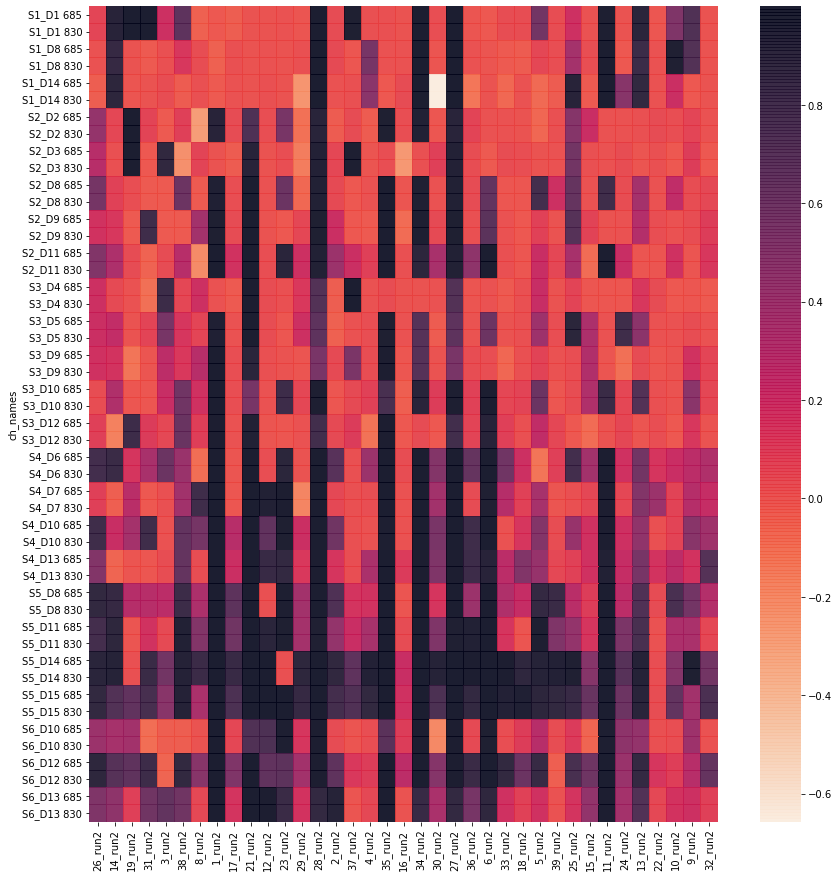

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(sci_df.set_index('ch_names'), cmap="rocket_r",alpha=0.9,square=True) # linewidths=.05,
plt.show()

# Channels Types: Motor x Parietal




In [ ]:
sci_df = pd.read_csv(path_in + 'sci_df.csv')
sci_df.head()

,ch_names,26_run2,14_run2,19_run2,31_run2,3_run2,38_run2,8_run2,1_run2,17_run2,...,39_run2,25_run2,15_run2,11_run2,24_run2,13_run2,22_run2,10_run2,9_run2,32_run2
0,S1_D1 685,0.057395,0.931106,0.996019,0.994430,0.186577,0.668012,-0.053278,-0.016575,-0.041005,...,0.027927,0.179980,0.004087,0.985930,0.000625,0.917335,-0.016334,0.520210,0.732059,0.002039
1,S1_D1 830,0.057395,0.931106,0.996019,0.994430,0.186577,0.668012,-0.053278,-0.016575,-0.041005,...,0.027927,0.179980,0.004087,0.985930,0.000625,0.917335,-0.016334,0.520210,0.732059,0.002039
2,S1_D8 685,0.003506,0.863003,0.001093,-0.023092,0.013705,0.128613,0.025721,-0.053213,0.012842,...,0.021787,0.362975,0.021367,0.996832,-0.021392,0.828339,0.006298,0.972279,0.717025,0.001597
3,S1_D8 830,0.003506,0.863003,0.001093,-0.023092,0.013705,0.128613,0.025721,-0.053213,0.012842,...,0.021787,0.362975,0.021367,0.996832,-0.021392,0.828339,0.006298,0.972279,0.717025,0.001597
4,S1_D14 685,-0.037049,0.903494,-0.006736,0.002185,0.024889,-0.035178,0.010002,-0.026717,0.008178,...,-0.030606,0.930694,-0.027317,0.999942,0.486424,0.878586,0.005808,0.193150,-0.017430,-0.000835


In [ ]:
channel_types_text = """S1_D1 = Hole 1 (D1 - B2) = Motor ; 
S1_D8 = Hole 9 ( D8 - B2)= Motor ; 
S1_D14 = Hole 20 (D6 - B3) = Motor ; 
S2_D2= Hole 2(B2-D2) = Motor ; 
S2_D3= Hole 3 (B2-D3) = Motor ; 
S2_D8= Hole 9 (D8 - D2) = Motor ; 
S2_D9= Hole 13  (D1 - B3) = Motor ; 
S2_D11= Hole 16 (D3 - B3) = Parietal ; 
S3_D4= Hole 4 (D4 - B2) = Parietal ; 
S3_D5= Hole 5 (D5- B2) = Parietal ; 
S3_D9= hole 13 (D1 - B3) = Motor ; 
S3_D10= Hole 14 (D2 - B3) = Parietal ; 
S3_D12= Hole 17 (D4 - B3) = Parietal ; 
S4_D6= Hole 6 ( |D6 - B2) = Parietal ; 
S4_D7= Hole 7 (D7 - B2) = Parietal ; 
S4_D10= Hole 14 (D2 - B3) = Parietal ; 
S4_D13= Hole 19 (D5 - B3) = Parietal ; 
S5_D8= Hole 9 (D8 - B1) = Motor ; 
S5_D11= Hole  16 (D3 - B3) = Parietal ; 
S5_D14= Hole 20 (D6 - B3) = Motor ; 
S5_D15= Hole 21 (D7 - B3) = Motor ; 
S6_D10= Hole 14 (D2 - B3) = Parietal ;
S6_D12= Hole 17 (D4 - B3) = Parietal ; 
S6_D13= Hole 19 (D5 - B3) = Parietal""" 

In [ ]:
import pandas as pd

channel_SD = pd.DataFrame()
channel_name = []
channel_type = []
channel_hole = []

for ch in channel_types_text.replace(' ','').replace('\n','').split(';'):
  channel_name.append( ch.split('=')[0] )
  channel_type.append( ch.split('=')[2] )
  channel_hole.append( ch.split('=')[1] )

channel_SD['channel_name'] = channel_name
channel_SD['channel_type'] = channel_type
channel_SD['channel_hole'] = channel_hole

channel_SD

,channel_name,channel_type,channel_hole
0,S1_D1,Motor,Hole1(D1-B2)
1,S1_D8,Motor,Hole9(D8-B2)
2,S1_D14,Motor,Hole20(D6-B3)
3,S2_D2,Motor,Hole2(B2-D2)
4,S2_D3,Motor,Hole3(B2-D3)
5,S2_D8,Motor,Hole9(D8-D2)
6,S2_D9,Motor,Hole13(D1-B3)
7,S2_D11,Parietal,Hole16(D3-B3)
8,S3_D4,Parietal,Hole4(D4-B2)
9,S3_D5,Parietal,Hole5(D5-B2)


In [ ]:
list( channel_SD[channel_SD.channel_type == 'Motor' ].channel_name )

['S1_D1',
 'S1_D8',
 'S1_D14',
 'S2_D2',
 'S2_D3',
 'S2_D8',
 'S2_D9',
 'S3_D9',
 'S5_D8',
 'S5_D14',
 'S5_D15']

In [ ]:
temp = pd.DataFrame({'sd':sci_df.ch_names.apply(lambda x: x.split(' ')[0])}).merge(channel_SD, left_on='sd', right_on='channel_name')
sci_df['channel_type'] = temp['channel_type']
sci_df.head()

,ch_names,26_run2,14_run2,19_run2,31_run2,3_run2,38_run2,8_run2,1_run2,17_run2,...,25_run2,15_run2,11_run2,24_run2,13_run2,22_run2,10_run2,9_run2,32_run2,channel_type
0,S1_D1 685,0.057395,0.931106,0.996019,0.994430,0.186577,0.668012,-0.053278,-0.016575,-0.041005,...,0.179980,0.004087,0.985930,0.000625,0.917335,-0.016334,0.520210,0.732059,0.002039,Motor
1,S1_D1 830,0.057395,0.931106,0.996019,0.994430,0.186577,0.668012,-0.053278,-0.016575,-0.041005,...,0.179980,0.004087,0.985930,0.000625,0.917335,-0.016334,0.520210,0.732059,0.002039,Motor
2,S1_D8 685,0.003506,0.863003,0.001093,-0.023092,0.013705,0.128613,0.025721,-0.053213,0.012842,...,0.362975,0.021367,0.996832,-0.021392,0.828339,0.006298,0.972279,0.717025,0.001597,Motor
3,S1_D8 830,0.003506,0.863003,0.001093,-0.023092,0.013705,0.128613,0.025721,-0.053213,0.012842,...,0.362975,0.021367,0.996832,-0.021392,0.828339,0.006298,0.972279,0.717025,0.001597,Motor
4,S1_D14 685,-0.037049,0.903494,-0.006736,0.002185,0.024889,-0.035178,0.010002,-0.026717,0.008178,...,0.930694,-0.027317,0.999942,0.486424,0.878586,0.005808,0.193150,-0.017430,-0.000835,Motor


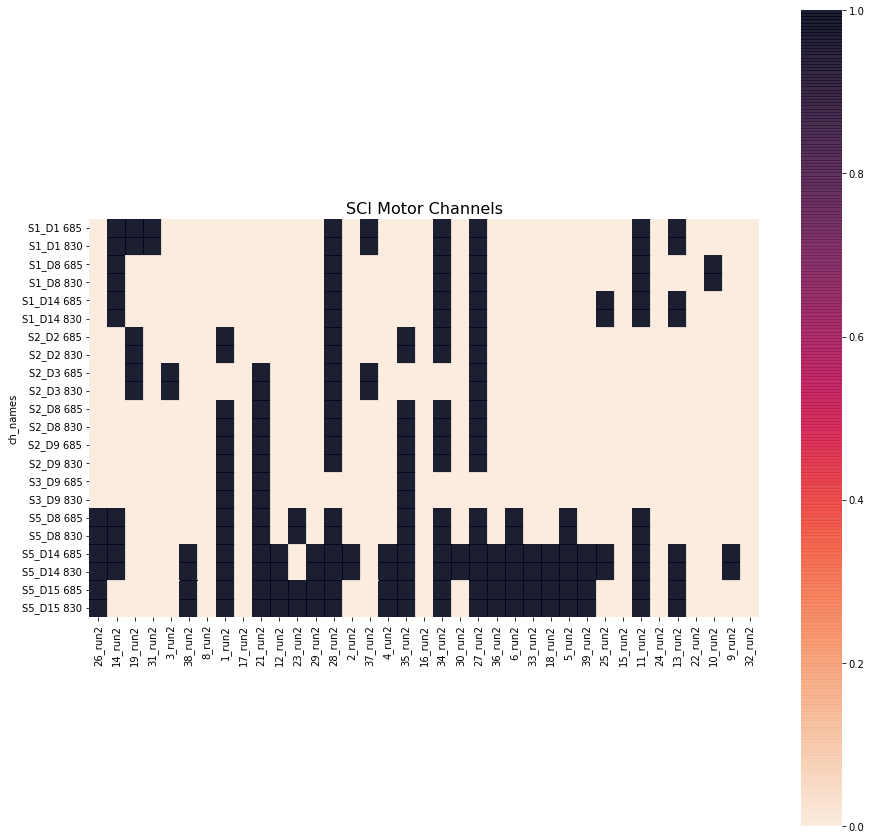

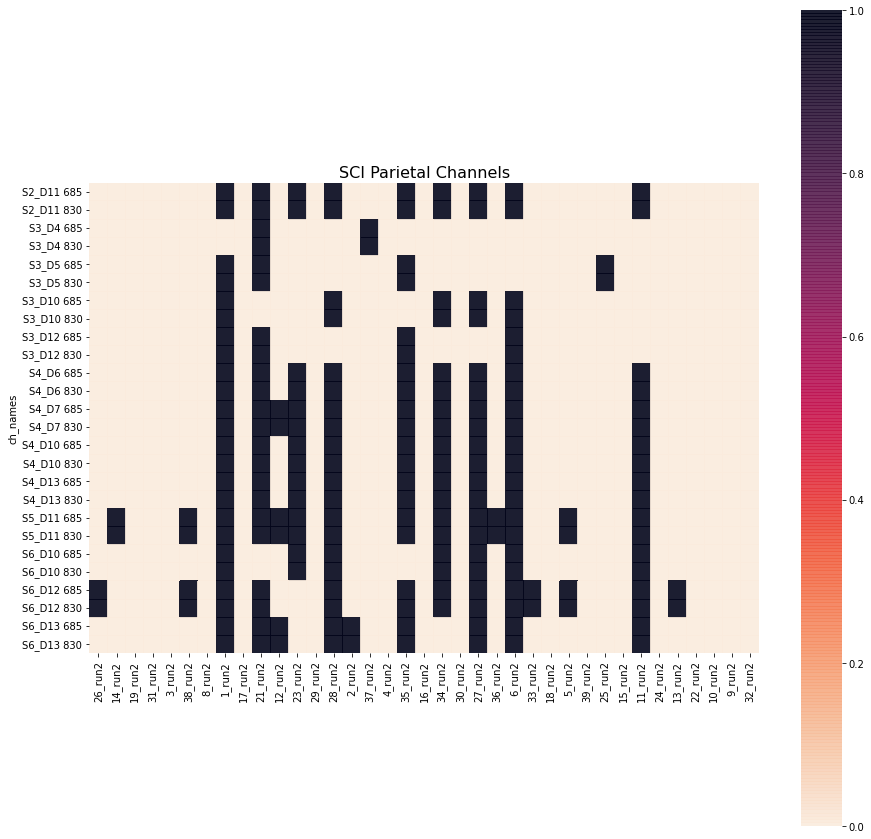

In [ ]:
plt.figure(figsize=(15,15))
sci_motor = sci_df[ sci_df.channel_type == 'Motor' ].set_index('ch_names').drop(columns='channel_type')
sns.heatmap(sci_motor > 0.85, cmap="rocket_r",alpha=0.9,square=True) # linewidths=.05,
plt.title('SCI Motor Channels',fontsize=16)
plt.show()

plt.figure(figsize=(15,15))
sci_parietal = sci_df[ sci_df.channel_type == 'Parietal' ].set_index('ch_names').drop(columns='channel_type')
sns.heatmap(sci_parietal > 0.85, cmap="rocket_r",alpha=0.9,square=True) # linewidths=.05,
plt.title('SCI Parietal Channels',fontsize=16)
plt.show()

# Retrieve one subject

['21_run2.snirf']
Loading /content/drive/MyDrive/Cond 2/snirf/21_run2.snirf
Reading 0 ... 22200  =      0.000 ...  2220.000 secs...


<ipython-input-112-9503bd813c8d>:21: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


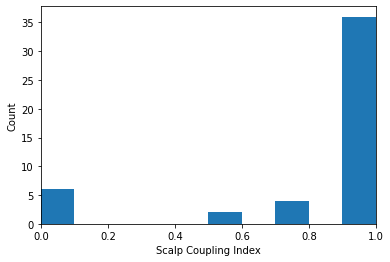

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


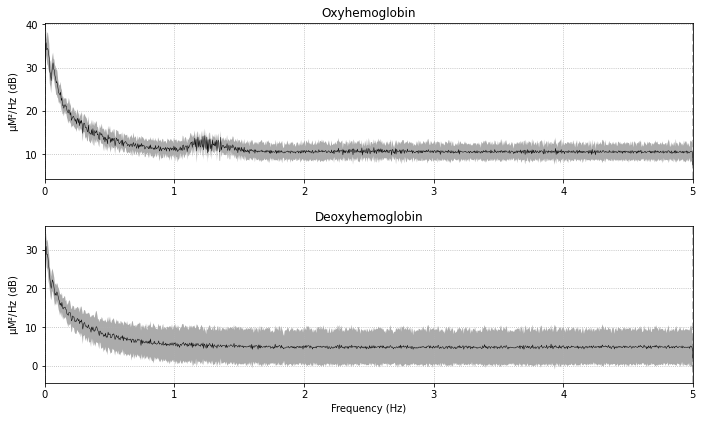

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


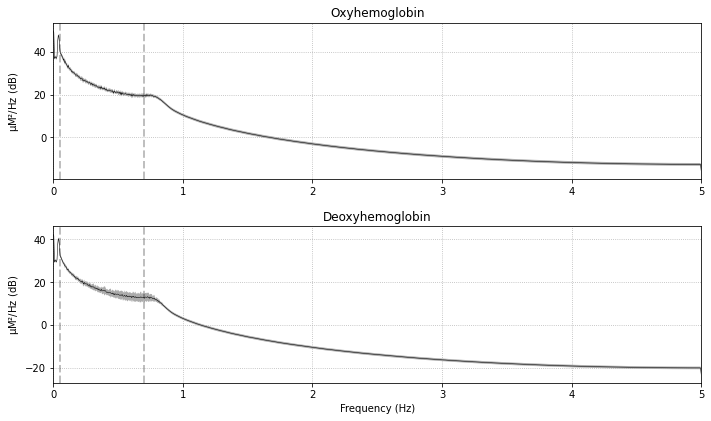

<Info | 10 non-empty values
 bads: 16 items (S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 ...)
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:24 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


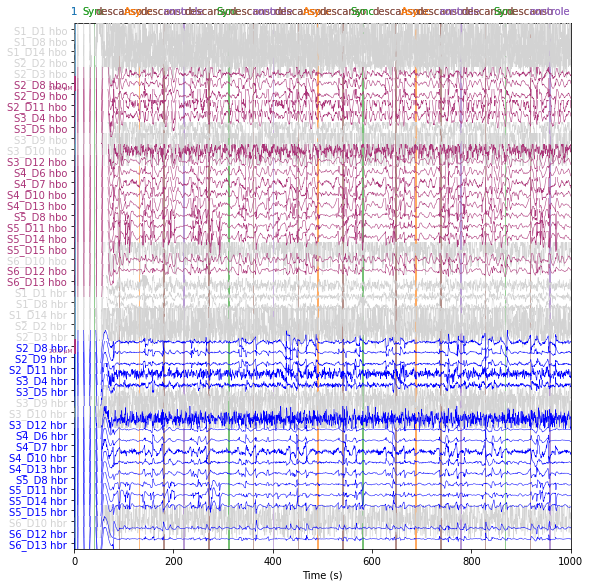

In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

subject = '21_run2'
threshold = 0.95

entries = [subject + '.snirf']
print(entries)

sci_df_exists = False
sci_df = pd.DataFrame()

raw_haemo_all = {}

for fname in entries:
  raw_intensity = mne.io.read_raw_snirf(path_in + 'snirf/' + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  fig, ax = plt.subplots()
  ax.hist(sci)
  ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
  plt.show()
  
  raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < threshold))
  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('Before filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                              l_trans_bandwidth=0.02)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('After filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  plt.show()

  print(raw_haemo.info)

  raw_haemo.plot(n_channels=48, duration=1000, show_scrollbars=False)
  plt.show()


    

In [ ]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -10, 18

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
#                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True,
                    event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
# epochs.plot_drop_log()

Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
24 matching events found
Setting baseline interval to [-10.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 281 original time points ...
0 bad epochs dropped


In [ ]:
epochs['controle']

Number of events,8
Events,controle: 8
Time range,-5.000 – 15.000 sec
Baseline,-5.000 – 0.000 sec


In [ ]:
styles_dict

{'Control': {'linestyle': 'dashed'}}

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


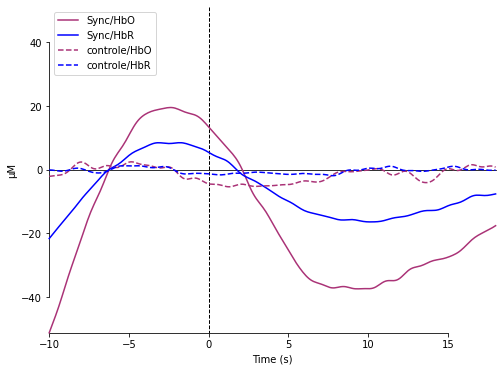

[<Figure size 576x432 with 1 Axes>]

In [ ]:
evoked_dict = {'Sync/HbO': epochs['Sync'].average(picks='hbo'),
               'Sync/HbR': epochs['Sync'].average(picks='hbr'),
               'controle/HbO': epochs['controle'].average(picks='hbo'),
               'controle/HbR': epochs['controle'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(controle=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


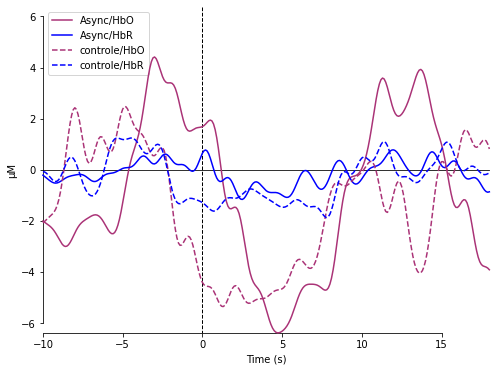

[<Figure size 576x432 with 1 Axes>]

In [ ]:
evoked_dict = {'Async/HbO': epochs['Async'].average(picks='hbo'),
               'Async/HbR': epochs['Async'].average(picks='hbr'),
               'controle/HbO': epochs['controle'].average(picks='hbo'),
               'controle/HbR': epochs['controle'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(controle=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

In [ ]:
import pickle

# To retrieve pickle
filename = path_in + 'raw_haemo_all.pickle'
infile = open(filename,'rb')
raw_haemo_all = pickle.load(infile)
infile.close()

raw_haemo_all.keys()

dict_keys(['26_run2', '14_run2', '19_run2', '31_run2', '3_run2', '38_run2', '8_run2', '1_run2', '17_run2', '21_run2', '12_run2', '23_run2', '29_run2', '28_run2', '2_run2', '37_run2', '4_run2', '35_run2', '16_run2', '34_run2', '30_run2', '27_run2', '36_run2', '6_run2', '33_run2', '18_run2', '5_run2', '39_run2', '25_run2', '15_run2', '11_run2', '24_run2', '13_run2', '22_run2', '10_run2', '9_run2', '32_run2'])

In [ ]:
subject = '27_run2'
raw_haemo = raw_haemo_all[subject]

In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


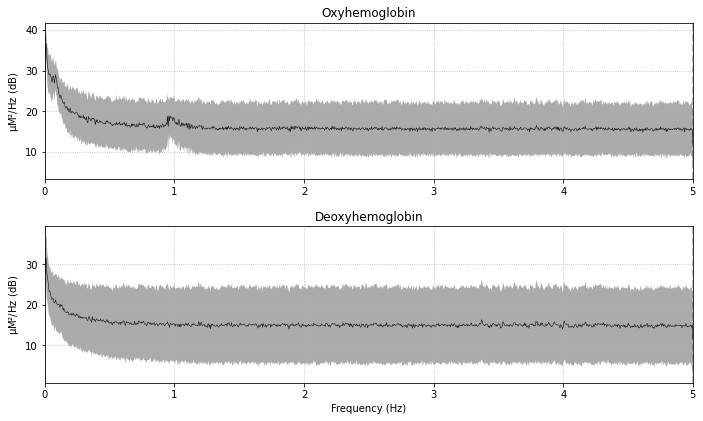

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


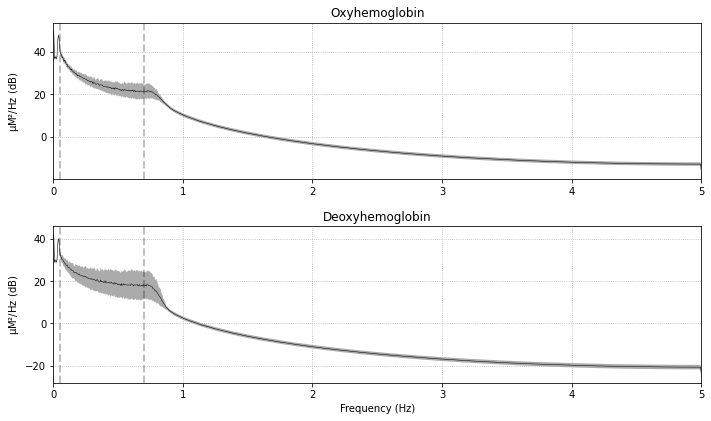

In [ ]:
fig = raw_haemo.plot_psd(average=True)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)

fig = raw_haemo.plot_psd(average=True)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

In [ ]:
raw_haemo.info

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:44 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>

In [ ]:
list( sci_df[ sci_df[subject] < 0.75 ].ch_names )

['S3_D4 685', 'S3_D4 830', 'S3_D5 685', 'S3_D5 830', 'S3_D9 685', 'S3_D9 830']

In [ ]:
raw_haemo.info['bads'] = list( sci_df[ sci_df[subject] < 0.75 ].ch_names )

In [ ]:
raw_haemo.info

<Info | 10 non-empty values
 bads: 6 items (S3_D4 685, S3_D4 830, S3_D5 685, S3_D5 830, S3_D9 685, ...)
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:44 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>

In [ ]:
events, _ = mne.events_from_annotations(raw_haemo)

Used Annotations descriptions: ['1', 'Async', 'Sync', 'controle', 'descanso']


In [ ]:
event_dict = {'Async': 2, 'Sync': 3, 'controle': 4}

<ipython-input-57-25ca181694ed>:2: RuntimeWarning: event 1 missing from event_id will be ignored
  sfreq=raw_haemo.info['sfreq'])
<ipython-input-57-25ca181694ed>:2: RuntimeWarning: event 5 missing from event_id will be ignored
  sfreq=raw_haemo.info['sfreq'])


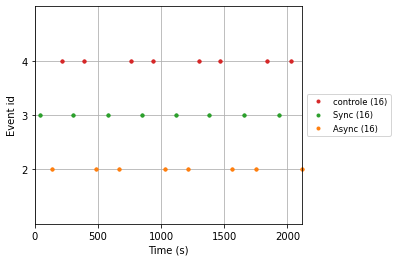

In [ ]:
fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

In [ ]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True,
                    event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
# epochs.plot_drop_log()

Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
24 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 201 original time points ...
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S1_D8 hbo', 'S1_D14 hbo', 'S2_D2 hbo', 'S2_D3 hbo', 'S2_D8 hbo', 'S2_D9 hbo', 'S2_D11 hbo', 'S3_D4 hbo', 'S3_D5 hbo', 'S3_D9 hbo', 'S3_D10 hbo', 'S3_D12 hbo', 'S4_D6 hbo', 'S4_D7 hbo', 'S4_D10 hbo', 'S4_D13 hbo', 'S5_D8 hbo', 'S5_D11 hbo', 'S5_D14 hbo', 'S5_D15 hbo', 'S6_D10 hbo', 'S6_D12 hbo', 'S6_D13 hbo']
    Rejecting  epoch based on HBO : ['S3_D4 hbo', 'S3_D5 hbo', 'S3_D9 hbo', 'S3_D12 hbo']
    Rejecting  epoch based on HBO : ['S3_D4 hbo', 'S3_D5 hbo', 'S3_D9 hbo', 'S5_D11 hbo', 'S5_D14 hbo']
    Rejecting  epoch based on HBO : ['S3_D4 hbo', 'S3_D5 hbo', 'S3_D9 hbo']
    Rejecting  epoch 

In [ ]:
hbo_hbr = {}

for c in ['Async', 'Sync', 'controle']:
  df_hbo = epochs[c].average(picks='hbo').to_data_frame()
  df_hbo = pd.melt(df_hbo, id_vars=['time'])
  df_hbr = epochs[c].average(picks='hbr').to_data_frame()
  df_hbr = pd.melt(df_hbr, id_vars=['time'])
  hbo_hbr[c] = {}
  hbo_hbr[c]['hbo'] = df_hbo
  hbo_hbr[c]['hbr'] = df_hbr

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-74-547f59161863>:4: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  df_hbo = epochs[c].average(picks='hbo').to_data_frame()
<ipython-input-74-547f59161863>:6: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  df_hbr = epochs[c].average(picks='hbr').to_data_frame()
<ipython-input-74-547f59161863>:4: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  df_hbo = epochs[c].average(picks='hbo').to_data_frame()
<ipython-input-74-547f59161863>:6: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  df_hbr = epochs[c].average(picks='hbr').to_data_frame()
<ipython-input-74-547f59161863>:4: RuntimeWarnin

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


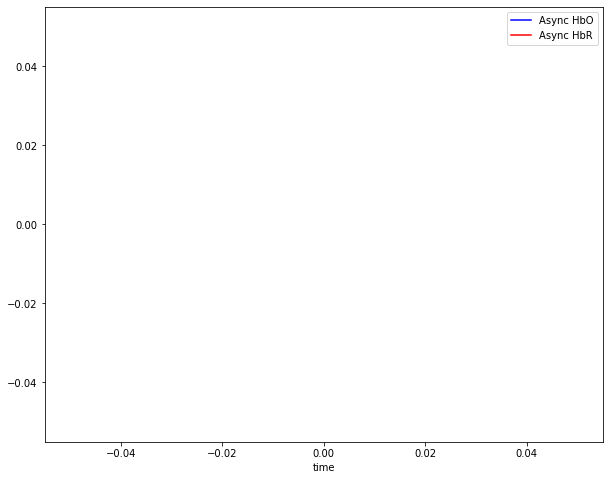

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


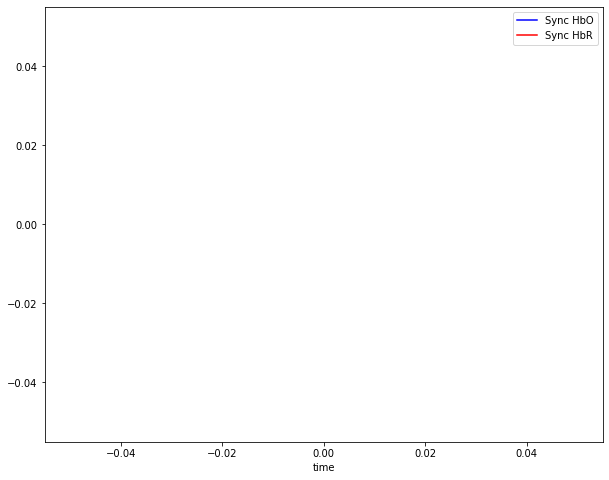

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


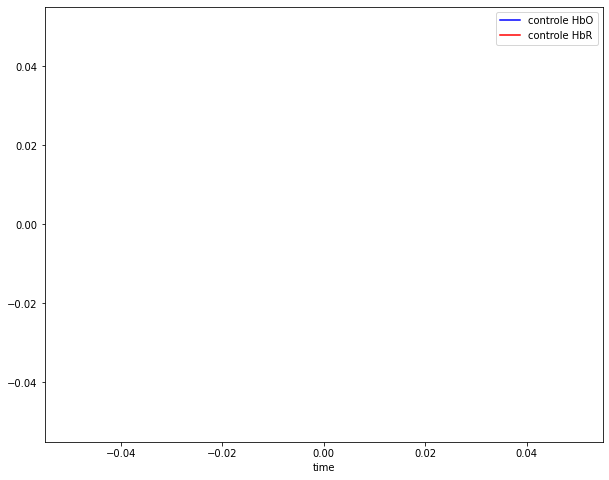

In [ ]:
for c in ['Async', 'Sync', 'controle']:

  plt.figure(figsize=(10,8))
  sns.lineplot(x=hbo_hbr[c]['hbo'].time, y=hbo_hbr[c]['hbo'].value,color='b',label= c + ' HbO',ci=99)
  sns.lineplot(x=hbo_hbr[c]['hbr'].time, y=hbo_hbr[c]['hbr'].value,color='r',label= c + ' HbR',ci=99)

  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-63-4223f471414e>:3: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  epochs['Async'].average().plot_image(axes=axes[:, 0], clim=clims)


ValueError: ignored

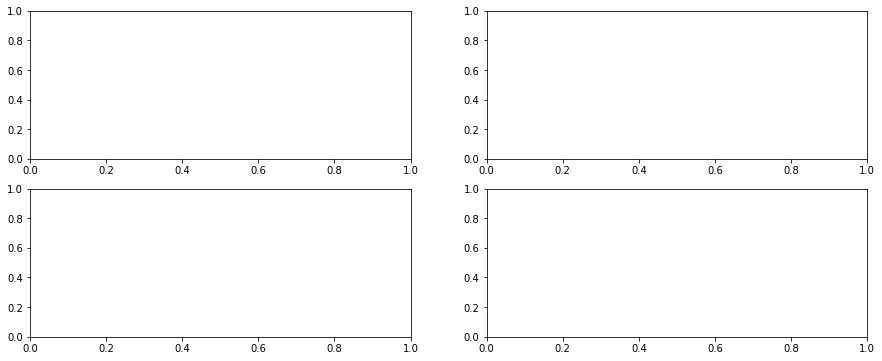

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
clims = dict(hbo=[-20, 20], hbr=[-20, 20])
epochs['Async'].average().plot_image(axes=axes[:, 0], clim=clims)
epochs['Sync'].average().plot_image(axes=axes[:, 1], clim=clims)
for column, condition in enumerate(['Async', 'Sync']):
    for ax in axes[:, column]:
      ax.set_title('{}: {}'.format(condition, ax.get_title()))

# Plot all `.snirf` created

aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["stim4"] 
stim5 = data["nirs"]["stim5"] 
****************************************************************************************************
* Plotting  12_run2.snirf
****************************************************************************************************




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

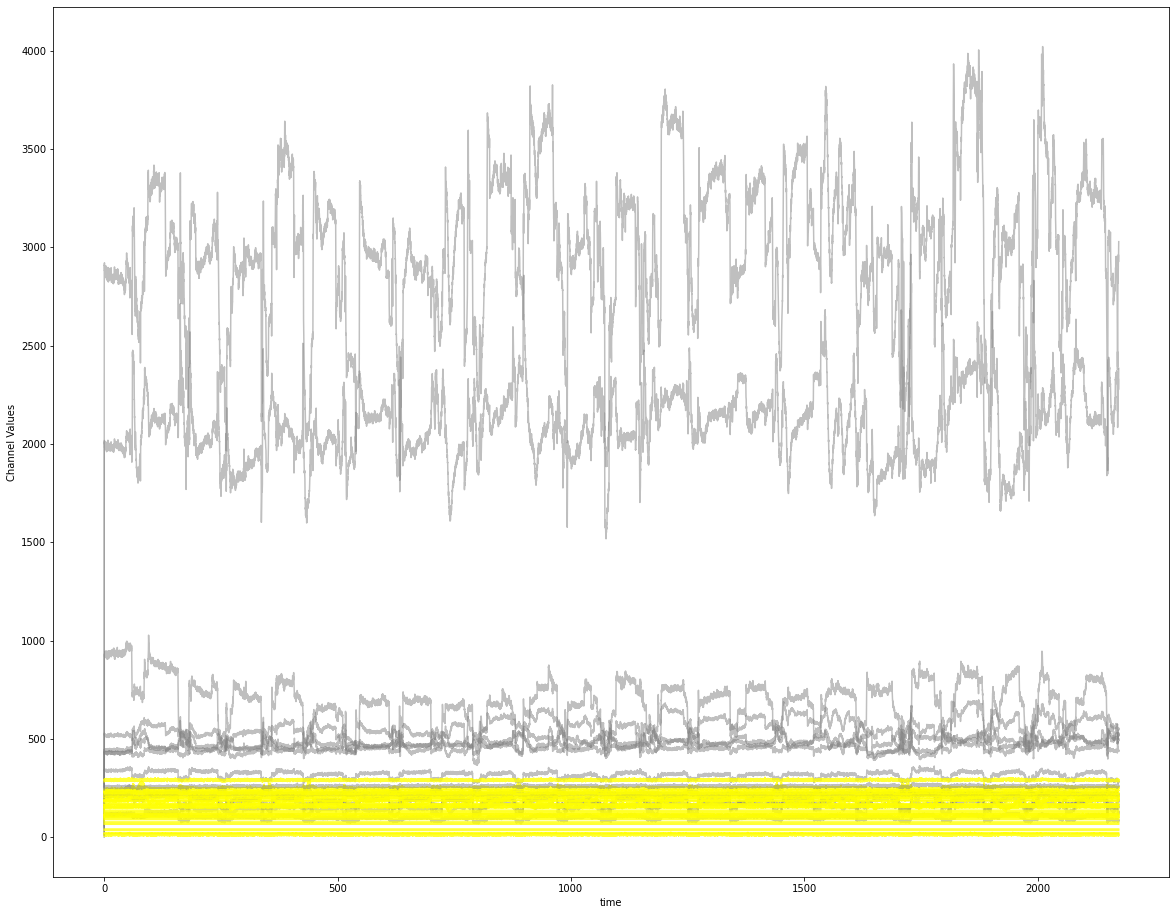

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

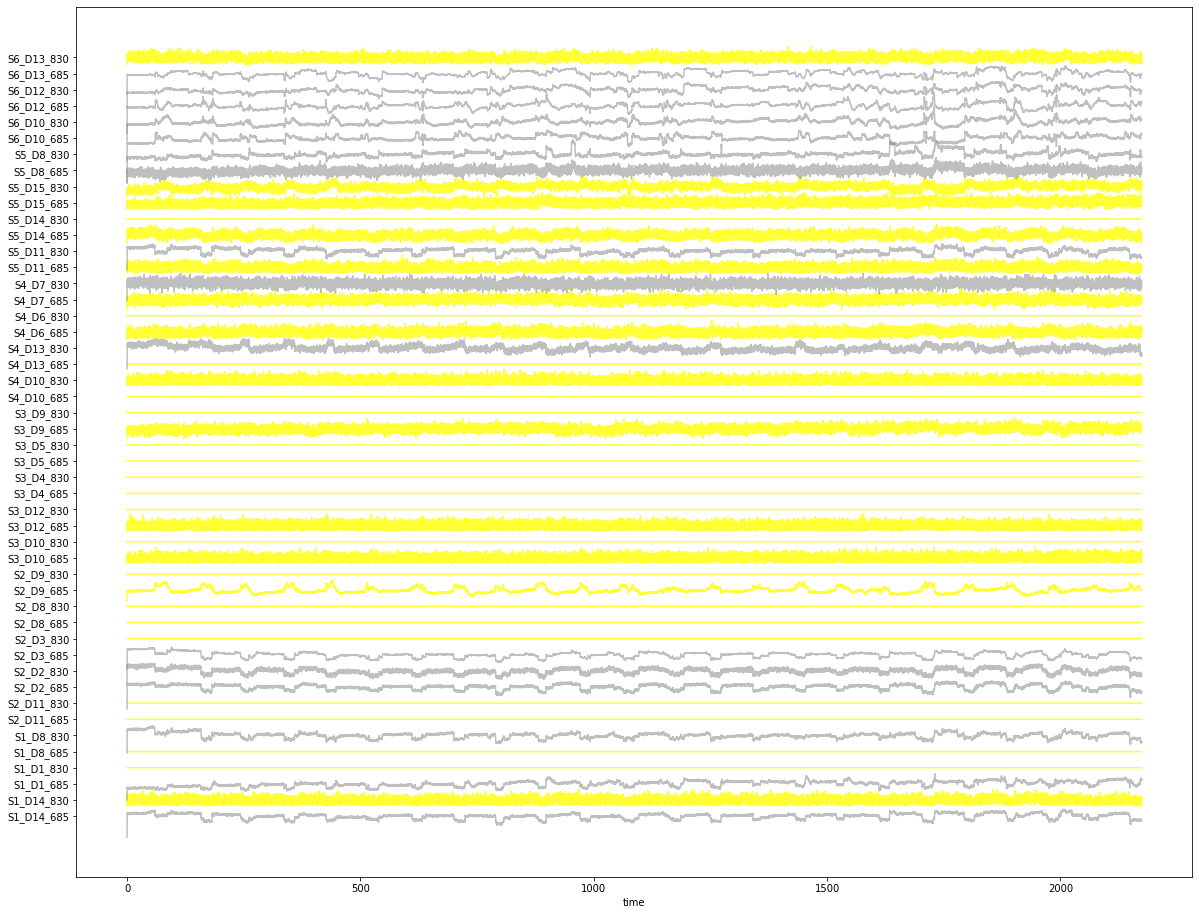

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

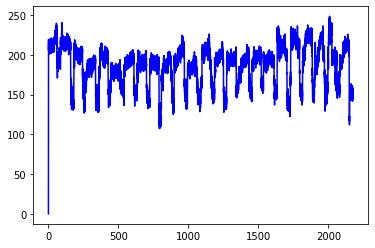

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

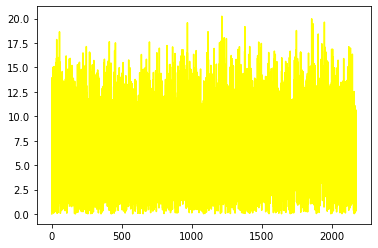

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

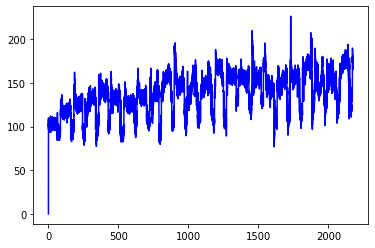

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

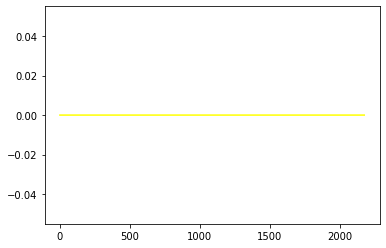

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

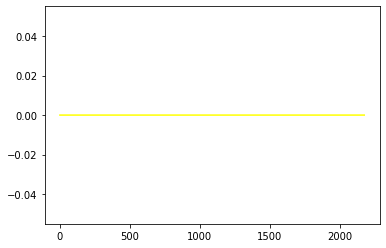

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

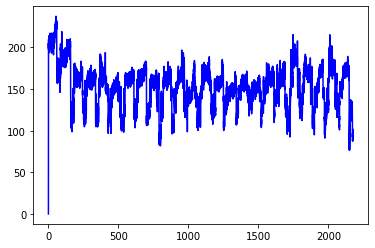

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

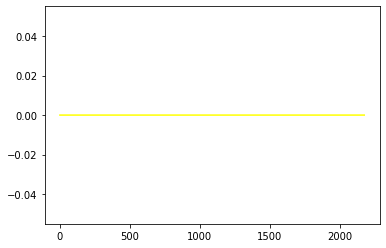

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

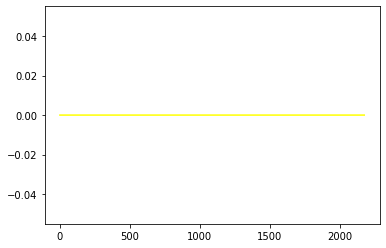

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

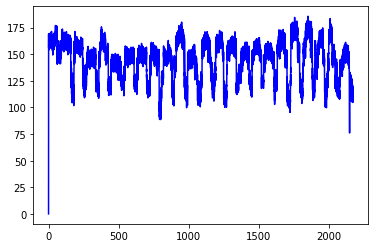

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

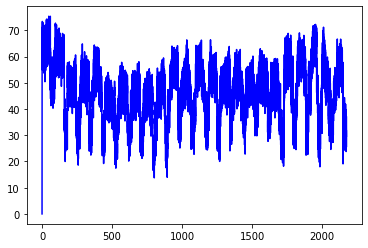

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

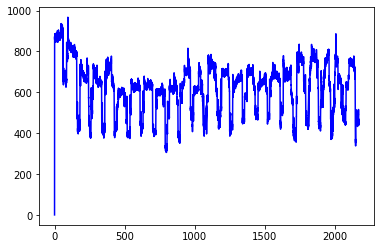

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

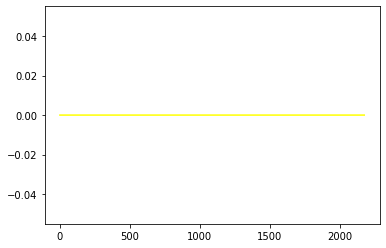

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

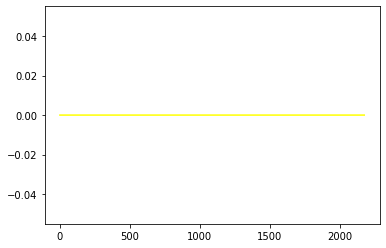

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

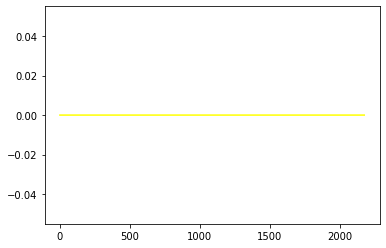

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

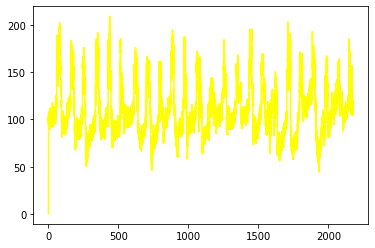

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

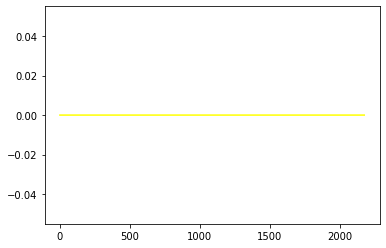

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

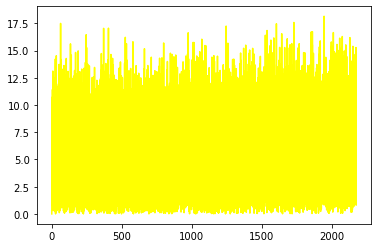

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

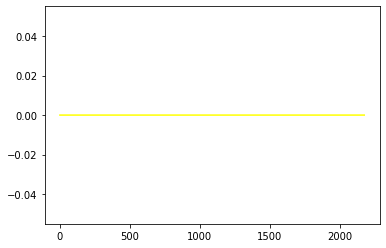

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

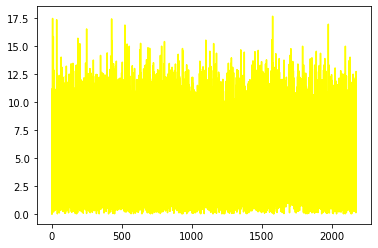

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

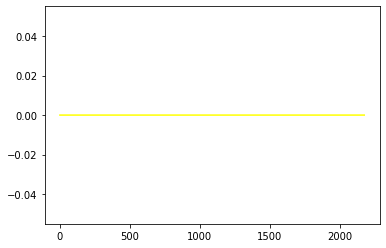

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

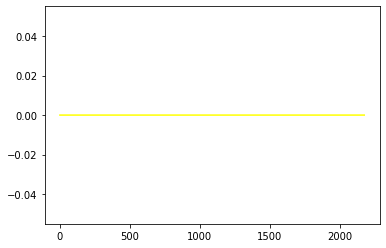

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

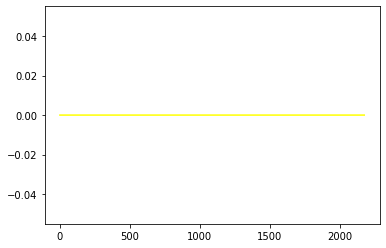

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

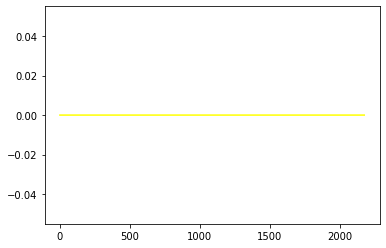

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

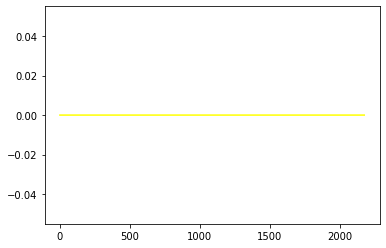

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

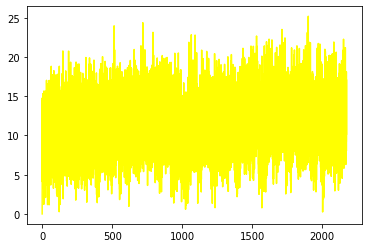

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

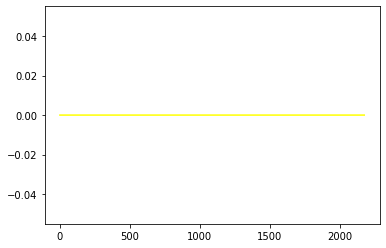

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

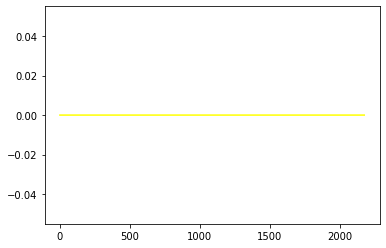

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

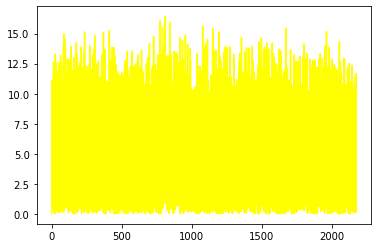

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

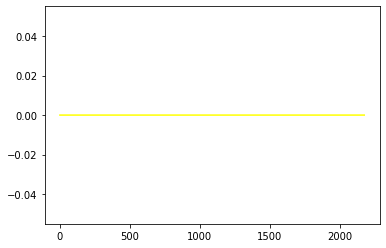

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

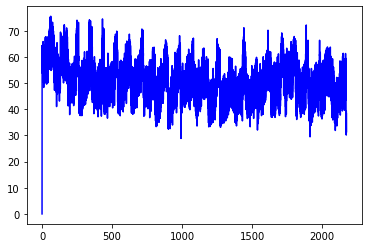

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

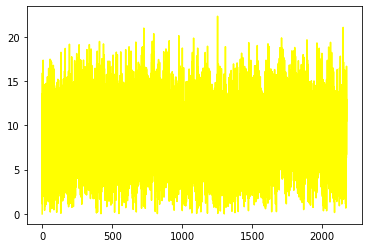

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

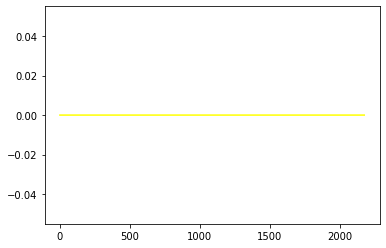

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

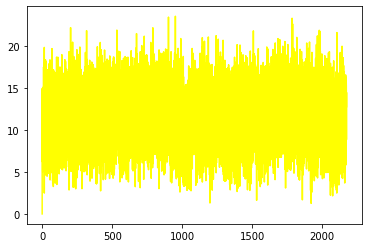

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

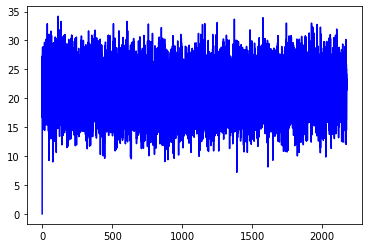

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

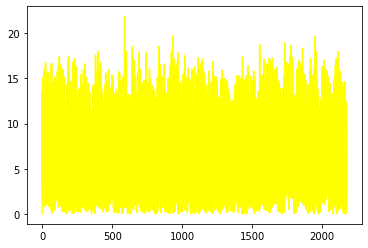

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

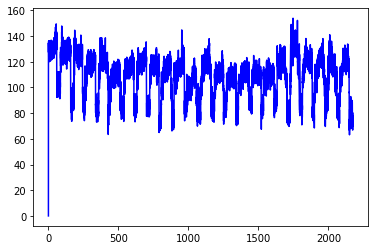

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

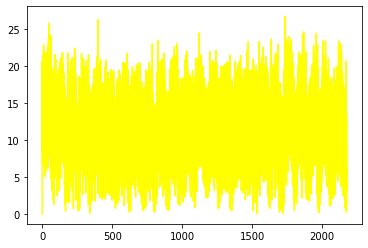

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

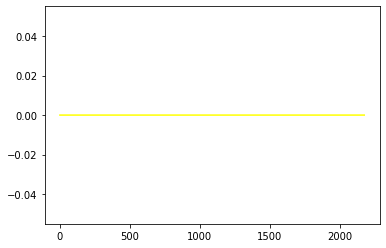

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

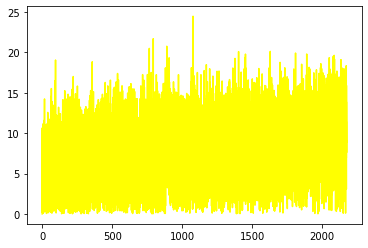

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

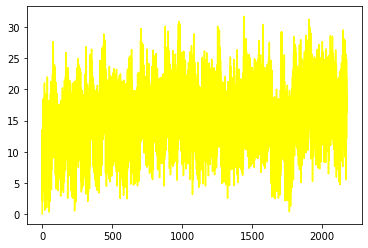

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

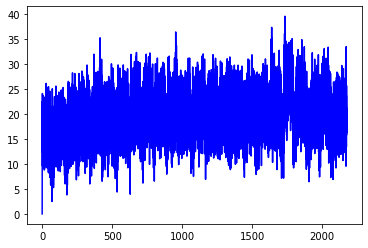

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

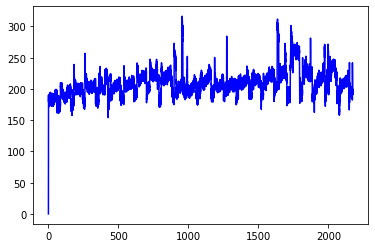

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

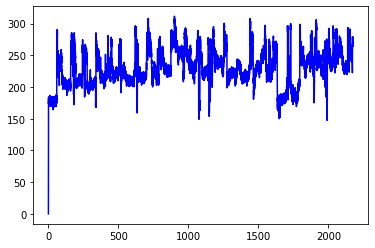

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

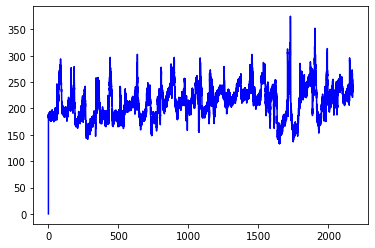

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

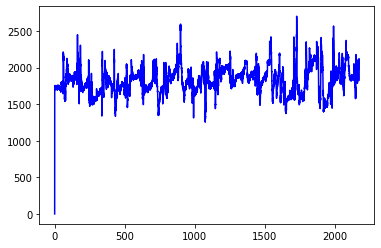

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

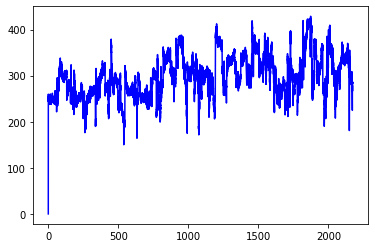

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

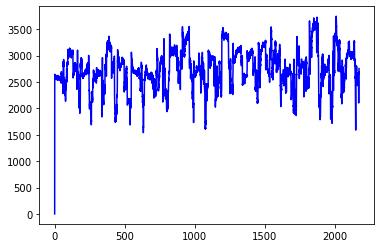

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

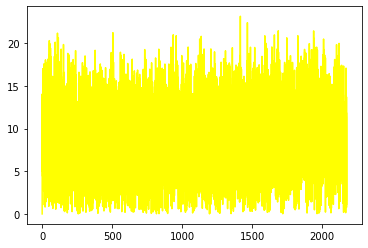

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,S1_D1_685,S2_D3_830,S2_D8_685,S2_D8_830,S2_D9_685,S2_D9_830,S2_D11_685,S2_D11_830,S3_D4_685,S3_D4_830,...,S6_D10_830,S6_D12_685,S6_D12_830,S6_D13_685,S6_D13_830,S1_D14_685,S1_D14_830,S2_D2_685,S2_D2_830,S2_D3_685
count,2.173900e+04,21739.0,21739.0,21739.0,2.173900e+04,21739.0,21739.0,21739.0,21739.0,21739.0,...,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04,2.173900e+04
mean,1.380806e+02,0.0,0.0,0.0,1.102945e+02,0.0,0.0,0.0,0.0,0.0,...,2.118299e+02,1.824151e+03,2.969094e+02,2.740861e+03,8.843219e+00,1.869537e+02,6.863870e+00,1.447250e+02,4.637785e+01,6.220612e+02
std,2.304476e+01,0.0,0.0,0.0,2.770325e+01,0.0,0.0,0.0,0.0,0.0,...,3.000502e+01,1.780097e+02,4.431228e+01,3.591668e+02,3.537488e+00,2.383824e+01,3.206231e+00,1.761243e+01,1.033067e+01,1.203518e+02
min,2.220446e-16,0.0,0.0,0.0,2.220446e-16,0.0,0.0,0.0,0.0,0.0,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
25%,1.222718e+02,0.0,0.0,0.0,9.098918e+01,0.0,0.0,0.0,0.0,0.0,...,1.886135e+02,1.706176e+03,2.642007e+02,2.550077e+03,6.391271e+00,1.730747e+02,4.560981e+00,1.315274e+02,3.907446e+01,5.402528e+02
50%,1.398342e+02,0.0,0.0,0.0,1.044767e+02,0.0,0.0,0.0,0.0,0.0,...,2.119055e+02,1.825284e+03,2.937057e+02,2.725796e+03,8.828348e+00,1.914473e+02,6.719600e+00,1.484683e+02,4.745902e+01,6.369239e+02
75%,1.557762e+02,0.0,0.0,0.0,1.244230e+02,0.0,0.0,0.0,0.0,0.0,...,2.308822e+02,1.933023e+03,3.273963e+02,2.984521e+03,1.123772e+01,2.024659e+02,9.032493e+00,1.576813e+02,5.362519e+01,7.006744e+02
max,2.262584e+02,0.0,0.0,0.0,2.092662e+02,0.0,0.0,0.0,0.0,0.0,...,3.747315e+02,2.700282e+03,4.289084e+02,3.744033e+03,2.316893e+01,2.485099e+02,2.024280e+01,1.857116e+02,7.535027e+01,9.674245e+02



Sample rate:  0.09999539997239984 in sec.
Total time:  2173.8 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)

Coeficientes de Variação, Threshold =  0.25  e Presença de Valores Negativos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


            coef_var  up_threshold  negative_values
S1_D1_685   0.166894         False            False
S2_D3_830   0.000000         False            False
S2_D8_685   0.000000         False            False
S2_D8_830   0.000000         False            False
S2_D9_685   0.251175          True            False
S2_D9_830   0.000000         False            False
S2_D11_685  0.000000         False            False
S2_D11_830  0.000000         False            False
S3_D4_685   0.000000         False            False
S3_D4_830   0.000000         False            False
S3_D5_685   0.000000         False            False
S1_D1_830   0.000000         False            False
S3_D5_830   0.000000         False            False
S3_D9_685   0.272429          True            False
S3_D9_830   0.000000         False            False
S3_D10_685  0.512276          True            False
S3_D10_830  0.000000         False            False
S3_D12_685  0.518039          True            False
S3_D12_830  

<IPython.core.display.Javascript object>



* End plotting  12_run2.snirf
****************************************************************************************************
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["stim4"] 
stim5 = data["nirs"]["stim5"] 
****************************************************************************************************
* Plotting  11_run2.snirf
*********************************************************************************

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

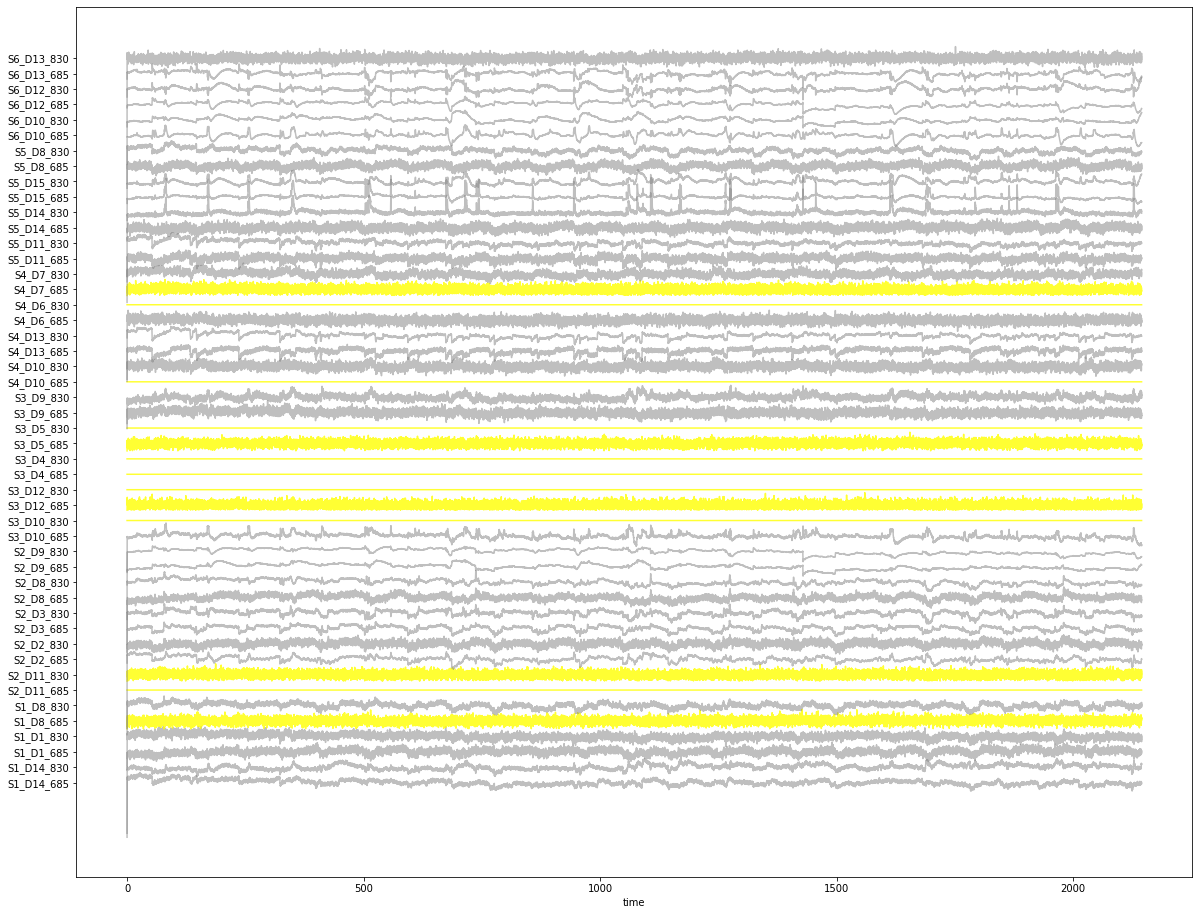

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,S1_D1_685,S2_D3_830,S2_D8_685,S2_D8_830,S2_D9_685,S2_D9_830,S2_D11_685,S2_D11_830,S3_D4_685,S3_D4_830,...,S6_D10_830,S6_D12_685,S6_D12_830,S6_D13_685,S6_D13_830,S1_D14_685,S1_D14_830,S2_D2_685,S2_D2_830,S2_D3_685
count,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,21447.0,2.144700e+04,21447.0,21447.0,...,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04,2.144700e+04
mean,3.203192e+01,1.985924e+02,7.687765e+01,5.528288e+02,7.500966e+02,3.411534e+03,0.0,6.829281e+00,0.0,0.0,...,6.285192e+02,3.512982e+03,2.983705e+02,1.543682e+03,2.892490e+01,2.232781e+02,3.471499e+02,1.834339e+03,3.359730e+01,2.112234e+02
std,4.626858e+00,1.655015e+01,6.563059e+00,3.815350e+01,1.064862e+02,4.165009e+02,0.0,2.733561e+00,0.0,0.0,...,9.646345e+01,4.022615e+02,4.076138e+01,1.691761e+02,3.561348e+00,1.130438e+01,1.271195e+01,6.840080e+01,4.490583e+00,2.299471e+01
min,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,0.0,2.220446e-16,0.0,0.0,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
25%,2.898161e+01,1.900687e+02,7.258898e+01,5.271553e+02,6.754753e+02,3.113074e+03,0.0,4.910646e+00,0.0,0.0,...,5.640760e+02,3.256667e+03,2.734408e+02,1.462627e+03,2.650801e+01,2.154961e+02,3.385796e+02,1.794313e+03,3.072000e+01,1.956873e+02
50%,3.226551e+01,2.014836e+02,7.698660e+01,5.522004e+02,7.446506e+02,3.467749e+03,0.0,6.812087e+00,0.0,0.0,...,6.201942e+02,3.589607e+03,2.926758e+02,1.561619e+03,2.892689e+01,2.225215e+02,3.467417e+02,1.831171e+03,3.383323e+01,2.167952e+02
75%,3.526981e+01,2.096988e+02,8.133063e+01,5.800247e+02,8.177460e+02,3.759064e+03,0.0,8.679988e+00,0.0,0.0,...,6.858867e+02,3.810973e+03,3.169019e+02,1.655285e+03,3.132420e+01,2.306996e+02,3.553351e+02,1.873997e+03,3.674849e+01,2.284904e+02
max,4.953886e+01,2.567766e+02,1.036939e+02,7.235686e+02,1.042611e+03,4.328458e+03,0.0,1.833408e+01,0.0,0.0,...,9.840923e+02,4.757846e+03,4.841013e+02,2.196734e+03,4.497293e+01,2.673393e+02,3.910544e+02,2.043814e+03,5.023563e+01,2.818181e+02



Sample rate:  0.09999533734321817 in sec.
Total time:  2144.6 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)

Coeficientes de Variação, Threshold =  0.25  e Presença de Valores Negativos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


            coef_var  up_threshold  negative_values
S1_D1_685   0.144445         False            False
S2_D3_830   0.083337         False            False
S2_D8_685   0.085370         False            False
S2_D8_830   0.069015         False            False
S2_D9_685   0.141963         False            False
S2_D9_830   0.122086         False            False
S2_D11_685  0.000000         False            False
S2_D11_830  0.400271          True            False
S3_D4_685   0.000000         False            False
S3_D4_830   0.000000         False            False
S3_D5_685   0.345730          True            False
S1_D1_830   0.086801         False            False
S3_D5_830   0.000000         False            False
S3_D9_685   0.161678         False            False
S3_D9_830   0.097751         False            False
S3_D10_685  0.073235         False            False
S3_D10_830  0.000000         False            False
S3_D12_685  0.513189          True            False
S3_D12_830  

<IPython.core.display.Javascript object>



* End plotting  11_run2.snirf
****************************************************************************************************
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["stim4"] 
stim5 = data["nirs"]["stim5"] 
****************************************************************************************************
* Plotting  10_run2.snirf
*********************************************************************************

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

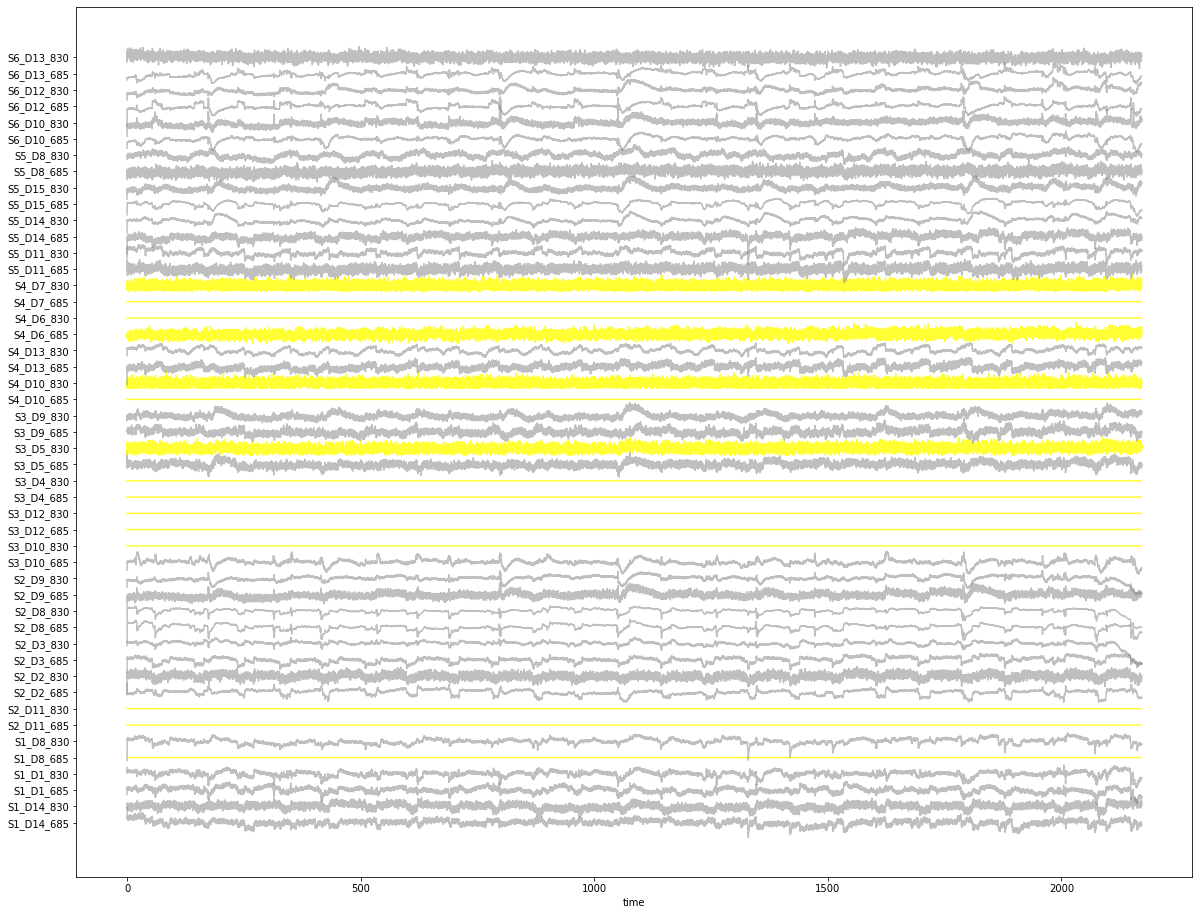

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,S1_D1_685,S2_D3_830,S2_D8_685,S2_D8_830,S2_D9_685,S2_D9_830,S2_D11_685,S2_D11_830,S3_D4_685,S3_D4_830,...,S6_D10_830,S6_D12_685,S6_D12_830,S6_D13_685,S6_D13_830,S1_D14_685,S1_D14_830,S2_D2_685,S2_D2_830,S2_D3_685
count,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.0,21717.0,21717.0,21717.0,...,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000,21717.000000
mean,225.394079,971.588165,3110.906672,14708.911120,31.961384,235.337748,0.0,0.0,0.0,0.0,...,54.894486,663.009315,122.558996,938.606229,19.986889,199.637122,41.332447,438.586290,34.345515,236.515790
std,11.749183,79.675898,208.878867,1511.762858,6.152707,28.466862,0.0,0.0,0.0,0.0,...,7.988184,72.607944,21.530848,117.571969,3.564688,8.672981,5.184986,34.939265,4.301859,20.492162
min,163.935257,343.640839,1715.957153,4854.525391,7.495483,62.534054,0.0,0.0,0.0,0.0,...,14.483222,133.346115,42.729008,493.860107,5.760280,153.069443,19.501862,309.370941,7.860108,140.996277
25%,218.028137,951.088074,3014.494141,14218.870117,27.678431,223.295456,0.0,0.0,0.0,0.0,...,49.487713,624.473633,109.749260,870.267273,17.590311,194.821899,38.037796,420.076630,31.505585,224.981018
50%,225.775757,979.862122,3141.522949,14971.704102,31.633493,238.858292,0.0,0.0,0.0,0.0,...,54.883255,661.929504,120.395821,946.675781,20.014374,200.418961,41.728649,446.490570,34.525604,239.127762
75%,233.634735,1008.968262,3232.189453,15596.167969,35.662666,252.652451,0.0,0.0,0.0,0.0,...,59.723206,704.114441,131.340515,1008.705200,22.397799,205.329361,44.949188,463.607422,37.361320,250.736038
max,262.962616,1160.958008,3724.687012,17558.376953,59.342579,322.982941,0.0,0.0,0.0,0.0,...,104.298569,914.907410,218.273712,1406.400757,34.223225,248.618530,58.193314,554.041077,49.642281,284.905884



Sample rate:  0.09999539531242804 in sec.
Total time:  2171.6 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)

Coeficientes de Variação, Threshold =  0.25  e Presença de Valores Negativos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


            coef_var  up_threshold  negative_values
S1_D1_685   0.052127         False            False
S2_D3_830   0.082006         False            False
S2_D8_685   0.067144         False            False
S2_D8_830   0.102779         False            False
S2_D9_685   0.192504         False            False
S2_D9_830   0.120962         False            False
S2_D11_685  0.000000         False            False
S2_D11_830  0.000000         False            False
S3_D4_685   0.000000         False            False
S3_D4_830   0.000000         False            False
S3_D5_685   0.123688         False            False
S1_D1_830   0.094082         False            False
S3_D5_830   0.371301          True            False
S3_D9_685   0.088852         False            False
S3_D9_830   0.134298         False            False
S3_D10_685  0.078875         False            False
S3_D10_830  0.000000         False            False
S3_D12_685  0.000000         False            False
S3_D12_830  

<IPython.core.display.Javascript object>



* End plotting  10_run2.snirf
****************************************************************************************************


In [ ]:
entries = os.listdir(out)

first = True

for fname in entries:
  data = h5py.File(out + fname,'r+')
  #
  # create alias for data['nirs']
  #
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
  #  print(exp)
    exec(exp)

  channels_table = create_channels_table(data)
  channels_raw = create_channels_raw(data)

  print(100*'*')
  print('* Plotting ', fname)
  print(100*'*') 
  print()
  print()
  
  if first:
    plotchannels_tab(channels_raw,reds=True,statistics=True) 
    first = False
  else:  
    plotchannels_tab(channels_raw, reds=True, all=False, statistics=True, individuals=False)

  print()
  print()
  print('* End plotting ', fname)
  print(100*'*') 

# Opcional, download files

In [ ]:
from google.colab import files

download = input('Deseja fazer download dos arquivos criados? (y|n)')

if download == 'y':
  entries = os.listdir(path_out)
  for f in entries:
    files.download(path_out + f)
